# Prototyping Label-efficient Semantic Segmentation With Diffusion Models paper

In [1]:
import diffusers
import torch
import lightning as L
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [6]:
from diffusers.models.unets.unet_2d import UNet2DModel

# unet = UNet2DModel(
#     sample_size=256,
#     in_channels=3,
#     out_channels=3,
#     block_out_channels=(128, 256, 512, 512),
#     down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
#     up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
# )

unet = UNet2DModel.from_pretrained("google/ddpm-church-256").to(device)

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

An error occurred while trying to fetch google/ddpm-church-256: google/ddpm-church-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

In [7]:
scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    prediction_type="epsilon",
)

In [8]:
activations_dict = {}

def save_activations(name):
    def hook(model, input, output):
        activations_dict[name] = output.detach()
    return hook

chosen_blocks = [0, 1, 2, 3]

for id in chosen_blocks:
    block = unet.up_blocks[id]
    block.register_forward_hook(save_activations(f"up_block_{id}"))

    if id == 3:
        block = unet.up_blocks[id].resnets[-1]
        block.register_forward_hook(save_activations(f"up_block_{id}_resnet_last"))

unet.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

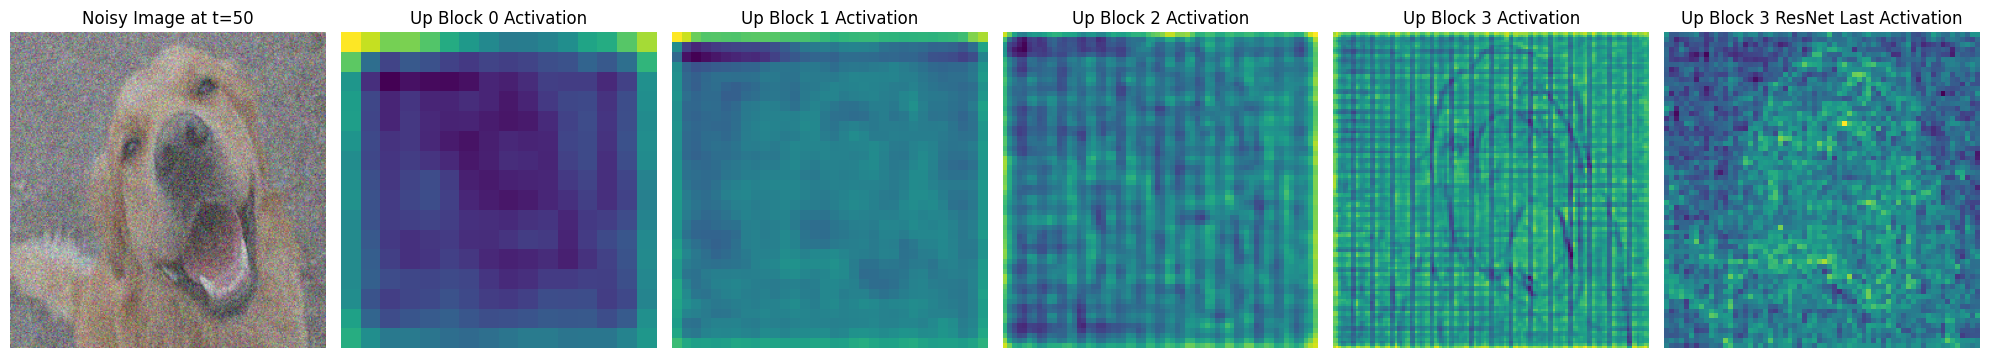

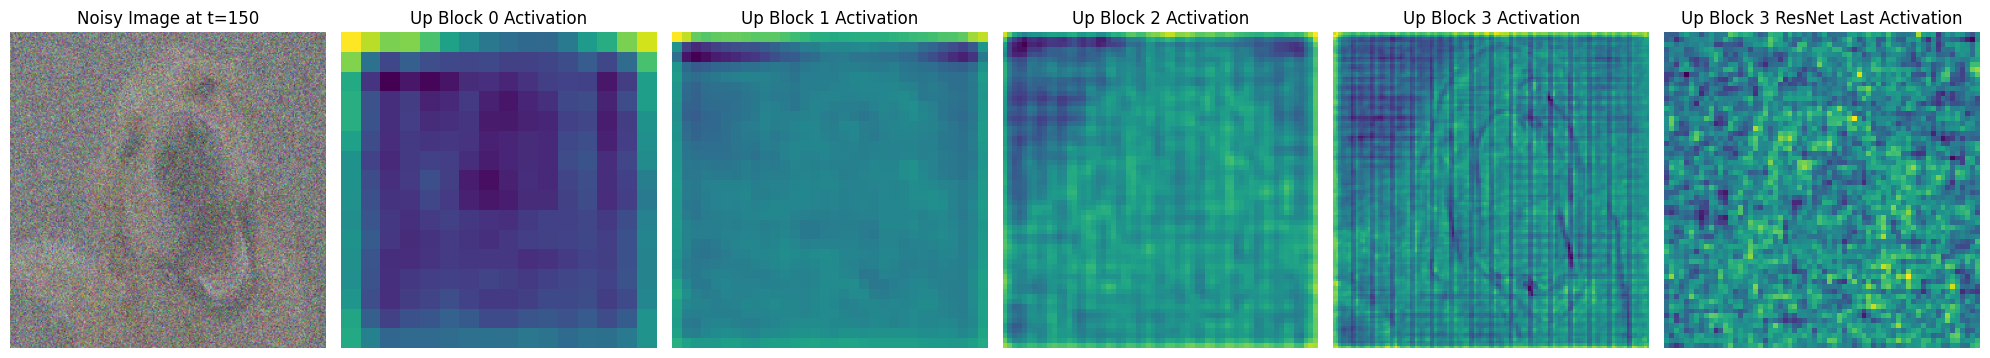

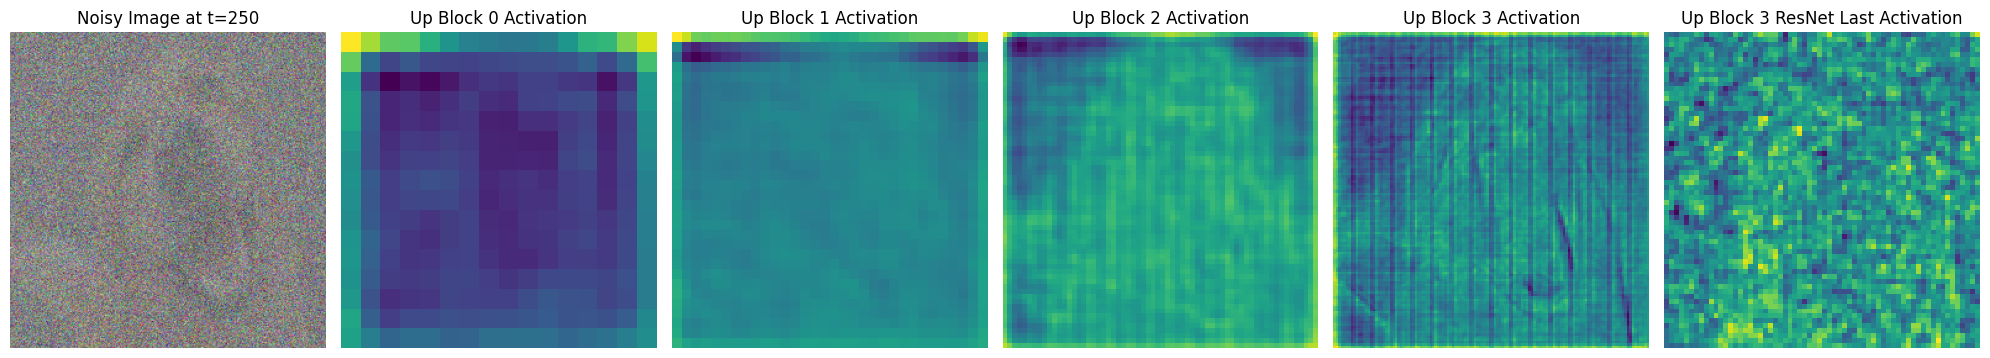

In [19]:
# load jpeg image
from PIL import Image
image_path = "../images.jpeg"  # replace with your image path
image = Image.open(image_path).convert("RGB")
image = image.resize((256, 256))
image = np.array(image).astype(np.float32) / 255.0
image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(device)
# generate noisy version xt at t = 50, 150, 250
timesteps = [50, 150, 250]
noisy_images = []

for t in timesteps:
    noisy_image = scheduler.add_noise(image, torch.randn_like(image), torch.tensor([t]).to(device))
    noisy_images.append((noisy_image, t))
# run through UNet, collect activations
outputs = []
for noisy_image, t in noisy_images:
    output = unet(noisy_image, torch.tensor([t]).to(device)).sample
    outputs.append(output)

# upsample each feature map to image resolution
upsampled_outputs = [torch.nn.functional.interpolate(output, size=(256, 256)) for output in outputs]

# visualize side-by-side: original, noisy, activation heatmaps

for i, t in enumerate(timesteps):
    noisy_image = scheduler.add_noise(image, torch.randn_like(image), torch.tensor([t]).to(device))
    output = unet(noisy_image, torch.tensor([t]).to(device)).sample
    # Convert noisy image to numpy for visualization
    noisy_image = noisy_image.cpu().squeeze().permute(1, 2, 0).detach().numpy()
    noisy_image = (noisy_image - noisy_image.min()) / (noisy_image.max() - noisy_image.min())
    noisy_image_out = output.cpu().squeeze().permute(1, 2, 0).detach().numpy()
    noisy_image_out = (noisy_image_out - noisy_image_out.min()) / (noisy_image_out.max() - noisy_image_out.min())

    fig, axes = plt.subplots(1, len(chosen_blocks) + 2, figsize=(20, 5))
    # Original/Noisy Image
    axes[0].imshow(noisy_image)
    axes[0].set_title(f"Noisy Image at t={t}")
    axes[0].axis('off')

    # Block Activations Heatmaps
    for j, block_id in enumerate(chosen_blocks):
        activation = activations_dict[f"up_block_{block_id}"].cpu().squeeze()
        # Compute the mean across the channel dimension
        activation_mean = activation.mean(dim=0).numpy()
        # Normalize to [0, 1]
        activation_mean = (activation_mean - activation_mean.min()) / (activation_mean.max() - activation_mean.min())
        
        # Plot heatmap
        sns.heatmap(activation_mean, ax=axes[j + 1], cmap='viridis', cbar=False) 
        axes[j + 1].set_title(f"Up Block {block_id} Activation")
        axes[j + 1].axis('off')
        # Set aspect to 'equal' to make the plot square
        axes[j + 1].set_aspect('equal') # 👈 Added this line

    # Last ResNet block of the last Up Block Heatmap
    activation = activations_dict[f"up_block_3_resnet_last"].cpu().squeeze()
    activation_mean = activation.mean(dim=0).numpy()
    activation_mean = (activation_mean - activation_mean.min()) / (activation_mean.max() - activation_mean.min())
    
    # Plot heatmap
    sns.heatmap(activation_mean, ax=axes[-1], cmap='viridis', cbar=False)
    axes[-1].set_title(f"Up Block 3 ResNet Last Activation")
    axes[-1].axis('off')
    # Set aspect to 'equal' to make the plot square
    axes[-1].set_aspect('equal') # 👈 Added this line

    plt.tight_layout()
    plt.show()